In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
import glob
import sys
sys.path.append("../scripts")
import preprocessing_census_blocks

In [2]:
# loading and census blocks
blocks_df = pd.read_csv("../data/blocks_patches_relation.csv")
blocks_df["mhi"] = blocks_df["mhi"].apply(lambda x: np.nan if x < 0 else x)
blocks_df["patches_relation"] = blocks_df["patches_relation"].apply(lambda x : np.nan if x == "{}" else x)
blocks_df = blocks_df.dropna()
print(f"Total of {blocks_df.shape[0]} blocks")

Total of 54477 blocks


In [3]:
blocks_geo_df = gpd.read_file("../data/census_blocks.geojson")
for col in ["state", "county", "tract", "block group"]:
    blocks_geo_df[col] = blocks_geo_df[col].astype(int)
blocks_df = blocks_df.merge(
    blocks_geo_df,
    how="left",
    on=["state", "county", "tract", "block group"],
    suffixes=("!", ""),
)
blocks_df = blocks_df.drop(columns=[col for col in blocks_df.columns if "!" in col])
blocks_df = gpd.GeoDataFrame(blocks_df, geometry="geometry")
blocks_df = blocks_df.to_crs("EPSG:4326")

In [4]:
blocks_df["patches_relation"] = blocks_df["patches_relation"].apply(literal_eval)
blocks_df["n_patches"] = blocks_df["patches_relation"].apply(len)
blocks_df["city_state"] = blocks_df.patches_relation.apply(lambda x : list(x.keys())[0].split("/")[0])

In [17]:
def get_n_scenes(x):
    return len(set([f.split("/")[1].split("_")[0] for f in x.keys()]))

def get_most_commom_scene(x):
    scenes_id = [f.split("/")[1].split("_")[0] for f in x.keys()]
    u, c = np.unique(scenes_id, return_counts=True)
    return u[np.argmax(c)]
blocks_df["n_scenes"] = blocks_df.patches_relation.apply(get_n_scenes)
blocks_df["most_commom_scene"] = blocks_df.patches_relation.apply(get_most_commom_scene)

In [18]:
blocks_df.n_patches.sum()

4415136

In [19]:
# keep only patches of the most commom scene
for i, row in blocks_df.iterrows():
    blocks_df.at[i, "patches_relation"] = {k: v for k, v in row.patches_relation.items() if k.split("/")[1].split("_")[0] == row.most_commom_scene}
blocks_df.n_patches = blocks_df.patches_relation.apply(len)

In [20]:
blocks_df.n_patches.sum()

3404215

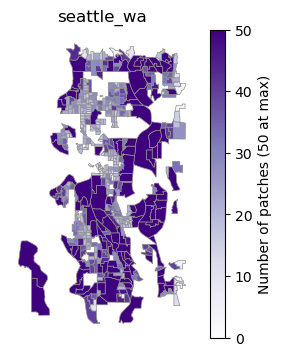

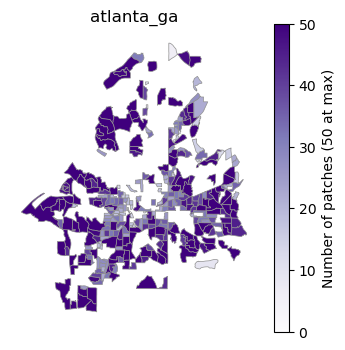

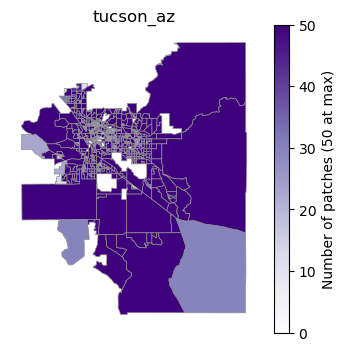

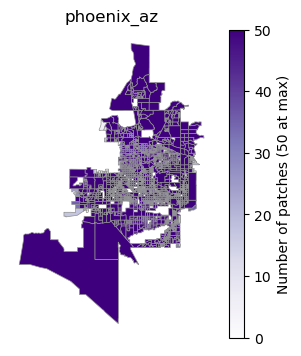

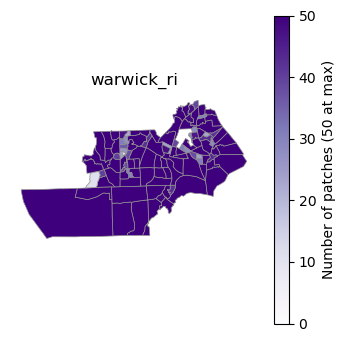

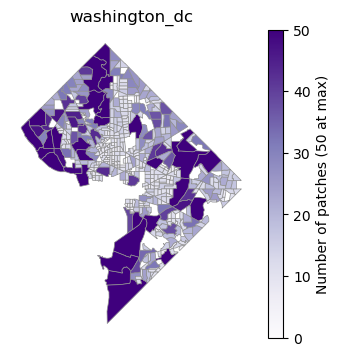

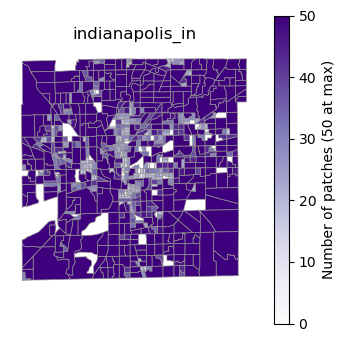

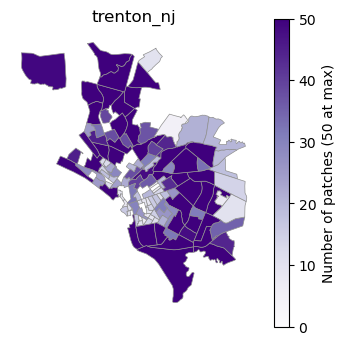

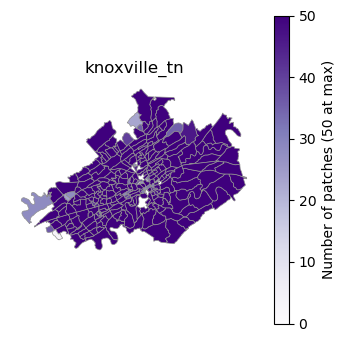

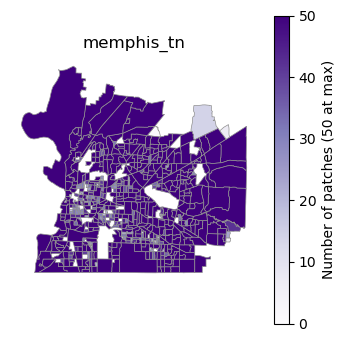

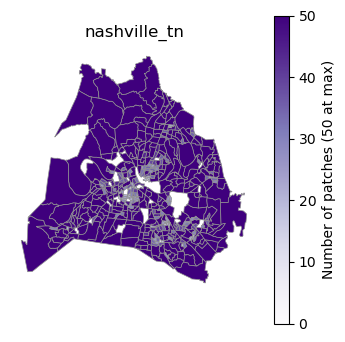

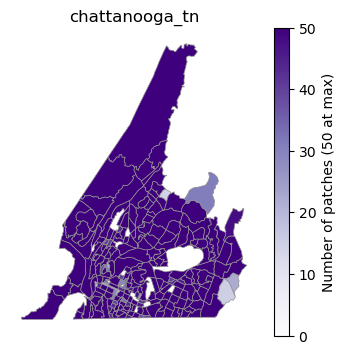

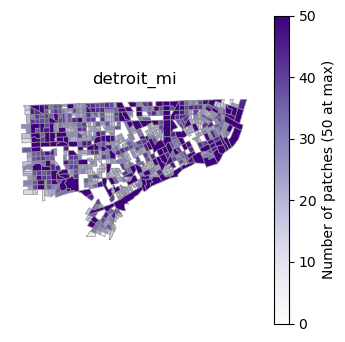

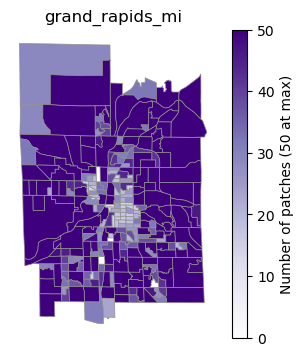

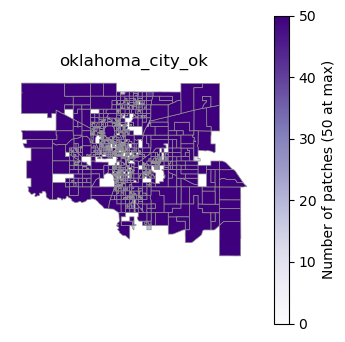

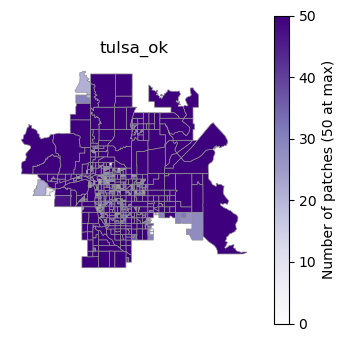

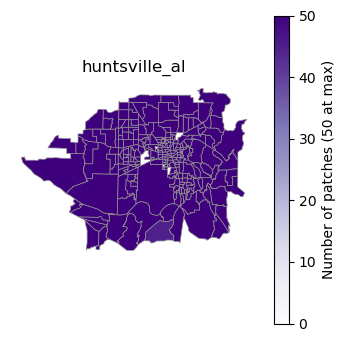

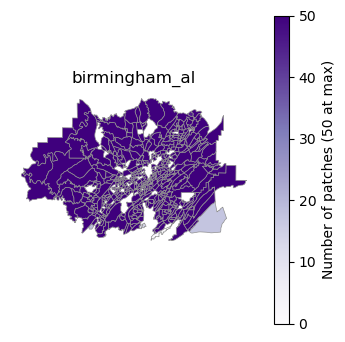

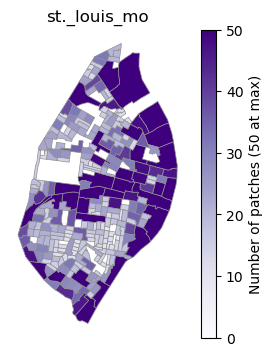

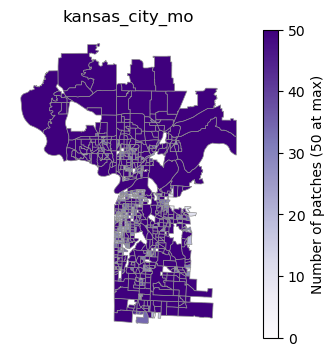

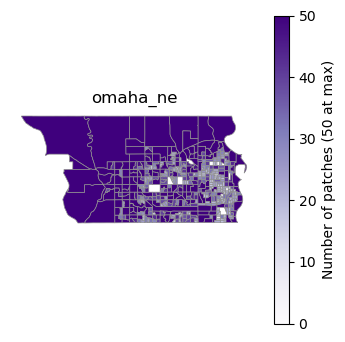

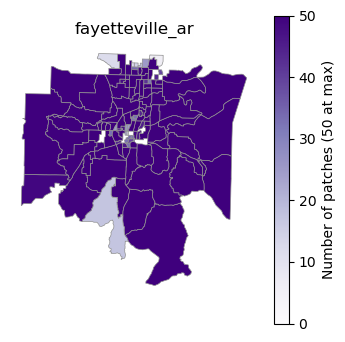

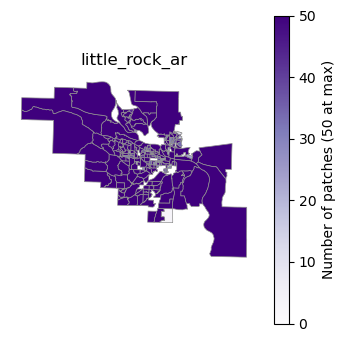

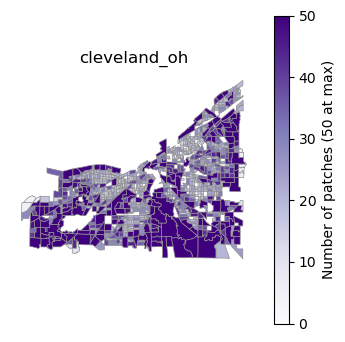

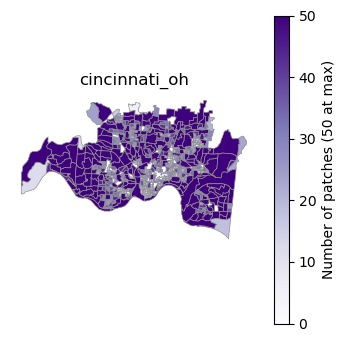

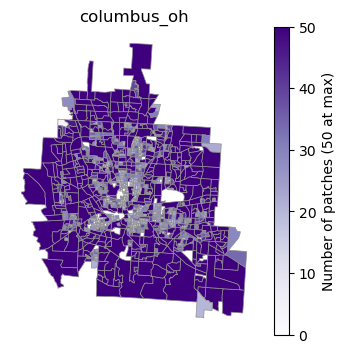

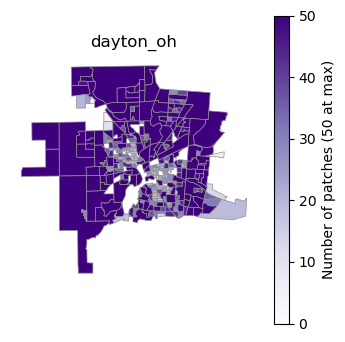

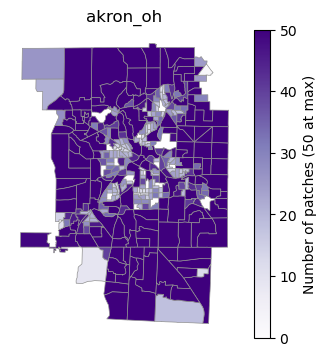

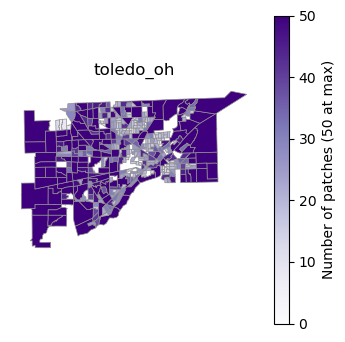

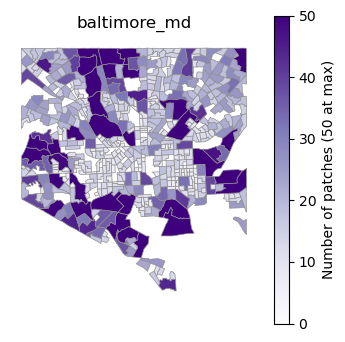

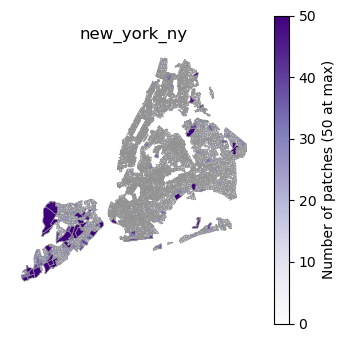

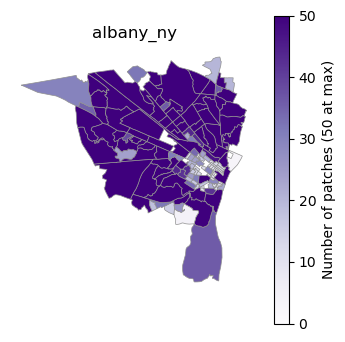

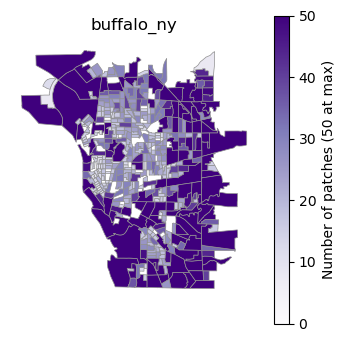

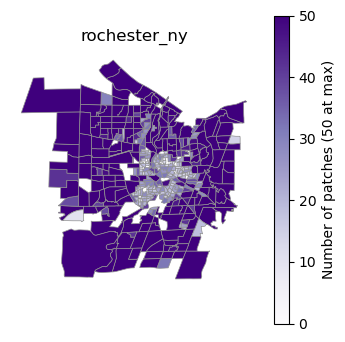

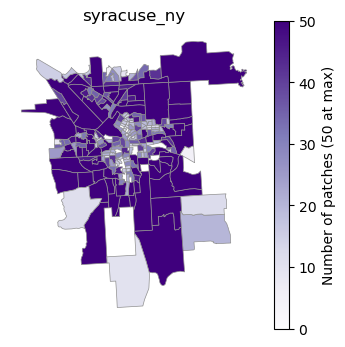

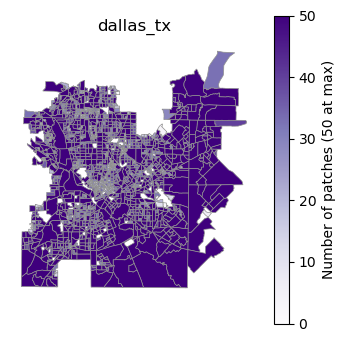

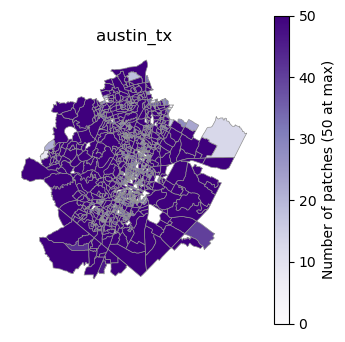

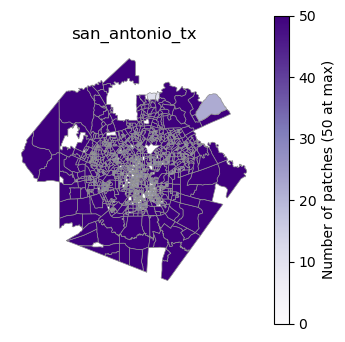

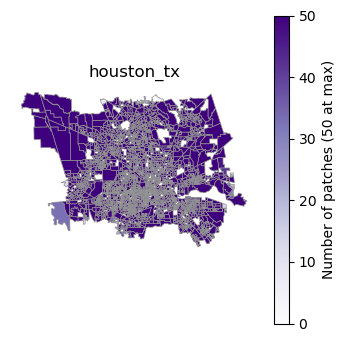

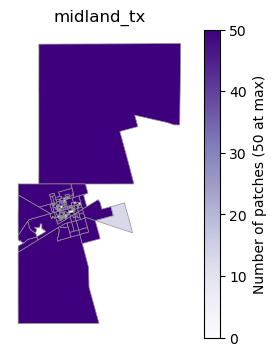

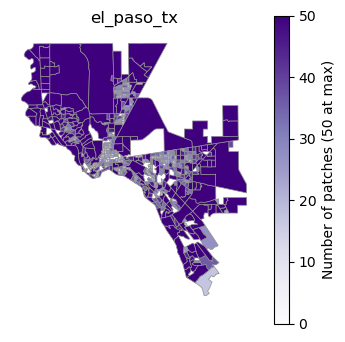

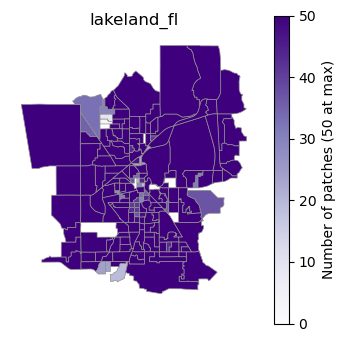

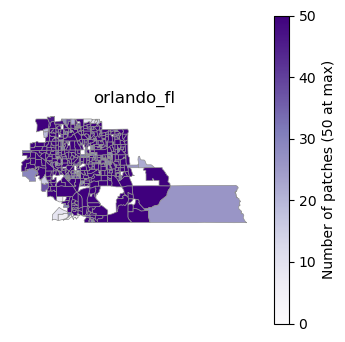

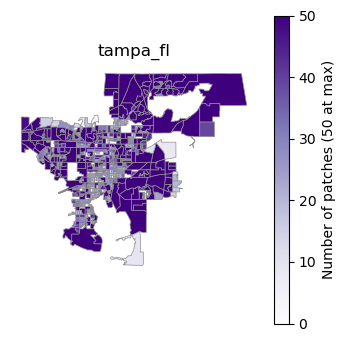

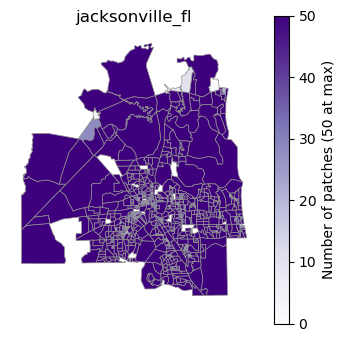

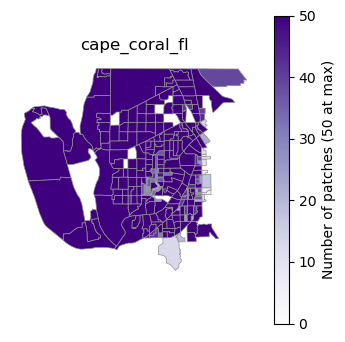

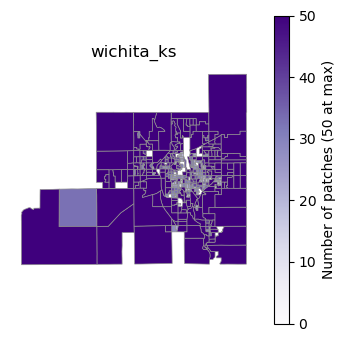

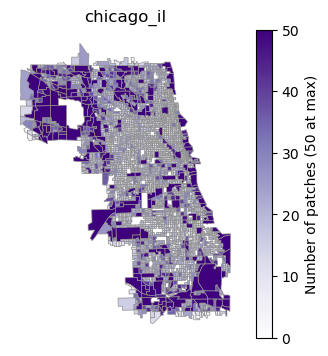

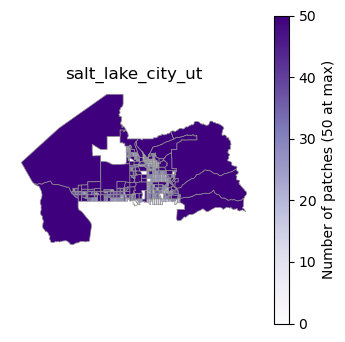

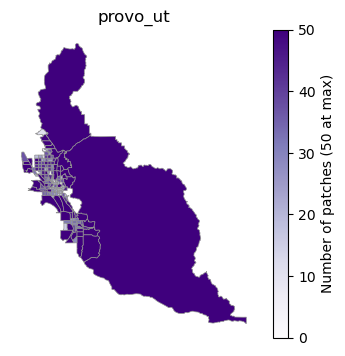

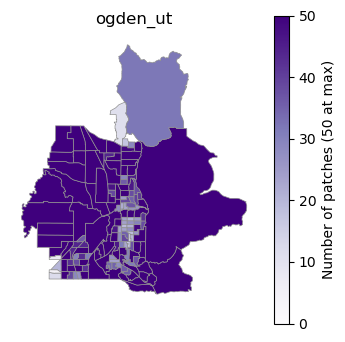

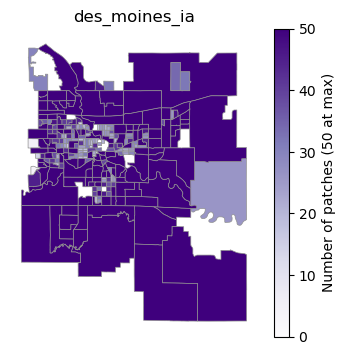

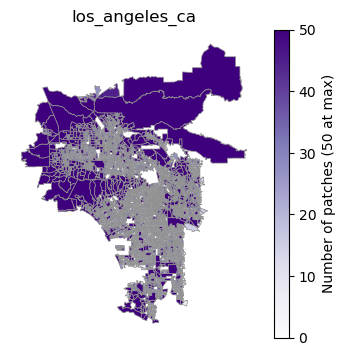

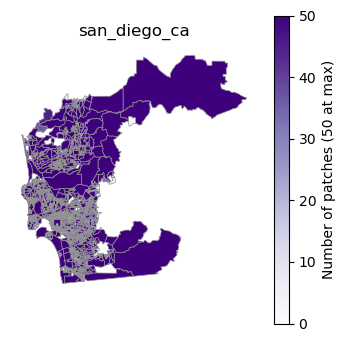

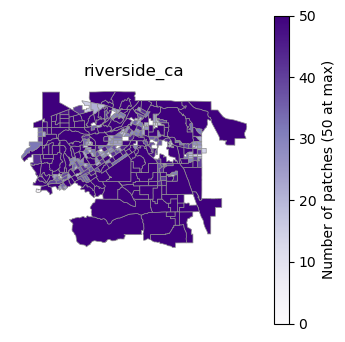

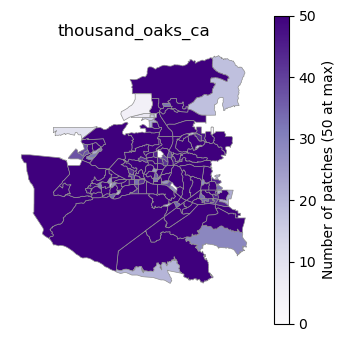

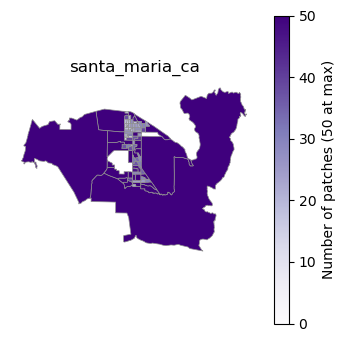

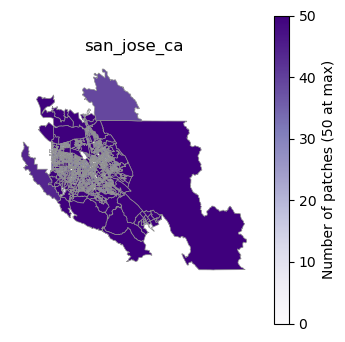

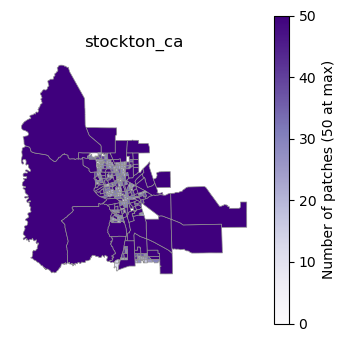

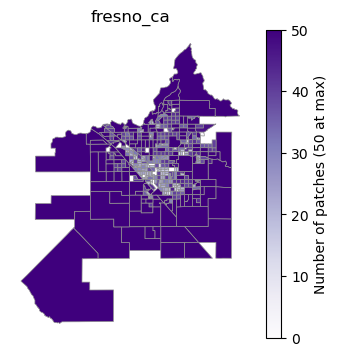

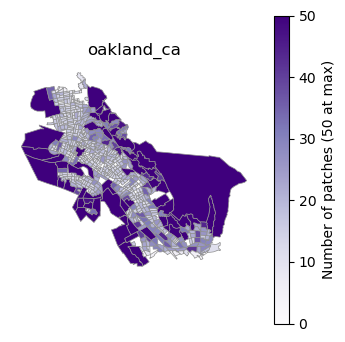

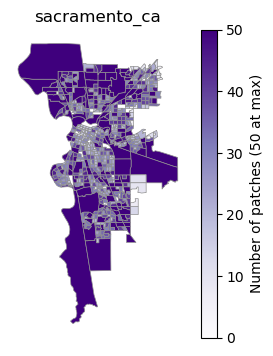

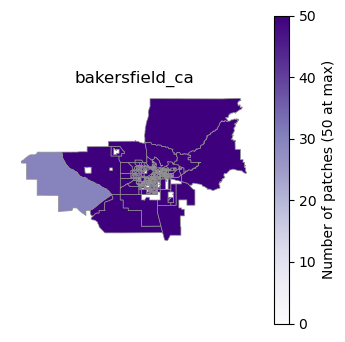

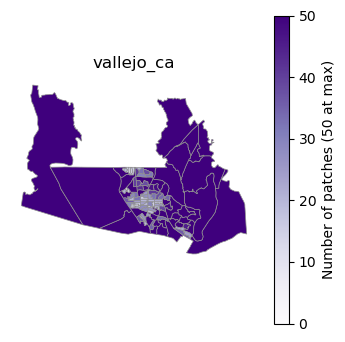

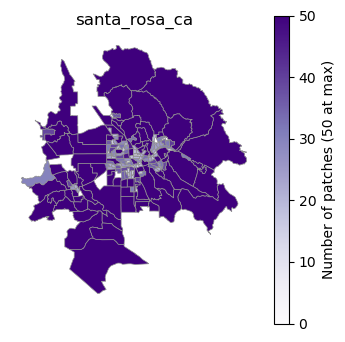

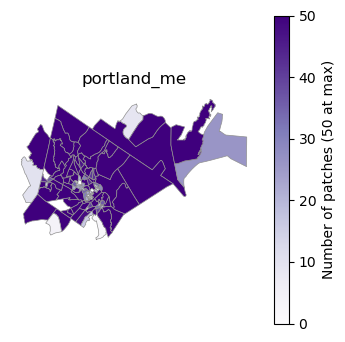

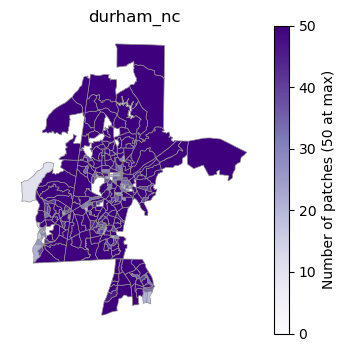

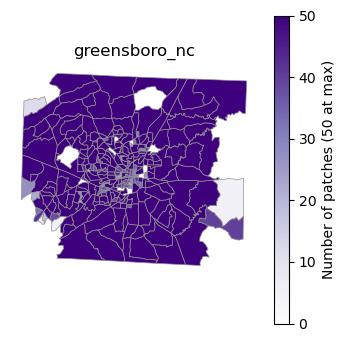

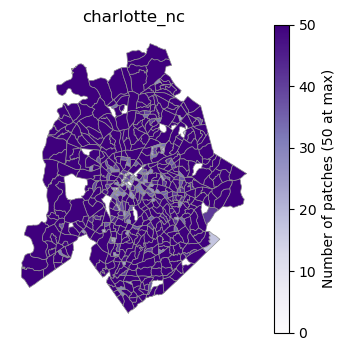

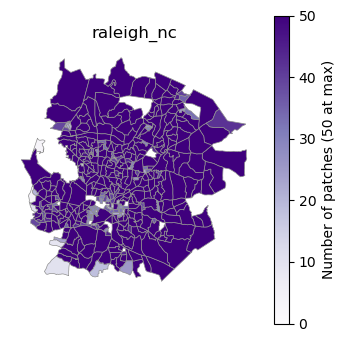

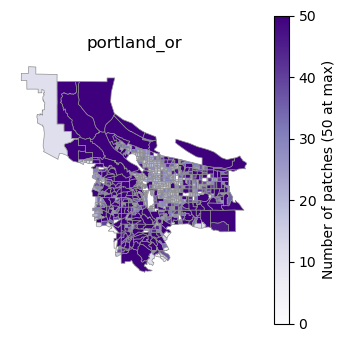

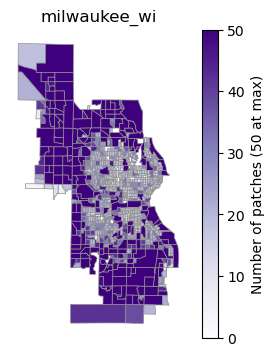

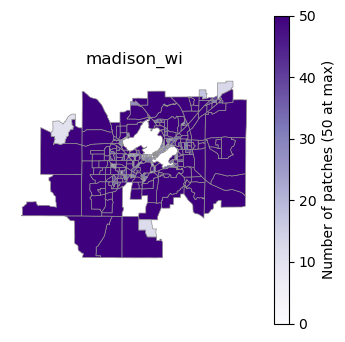

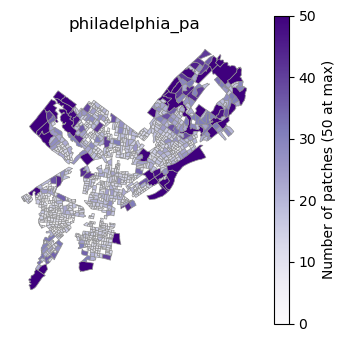

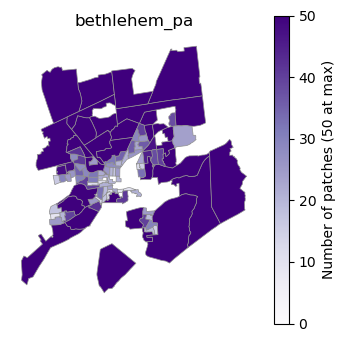

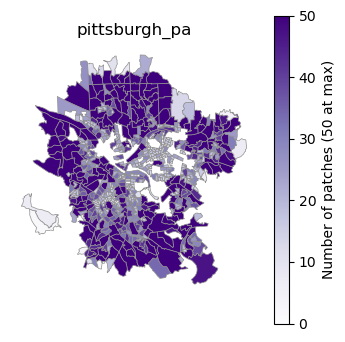

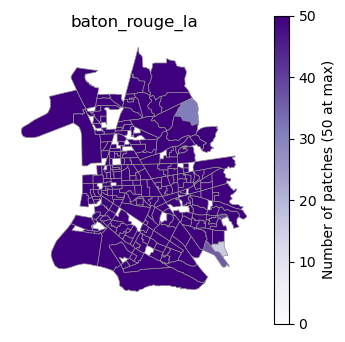

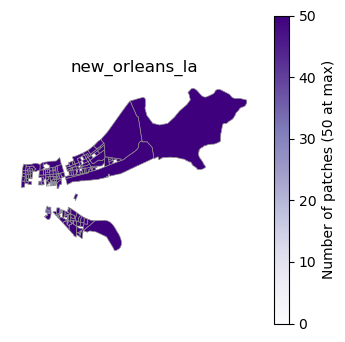

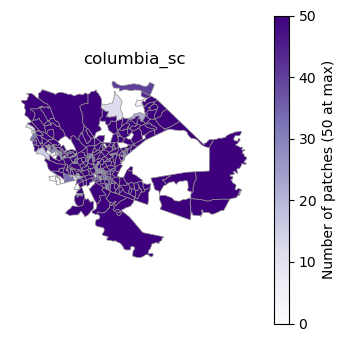

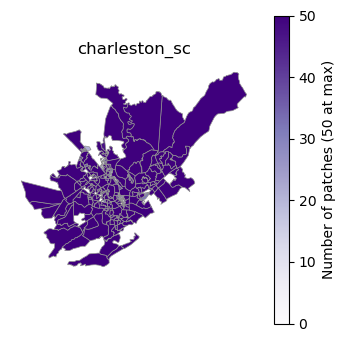

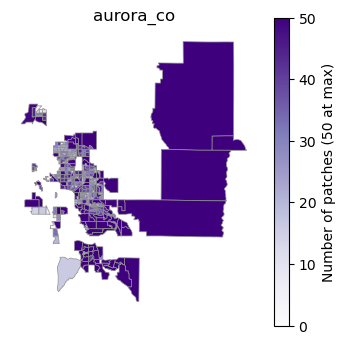

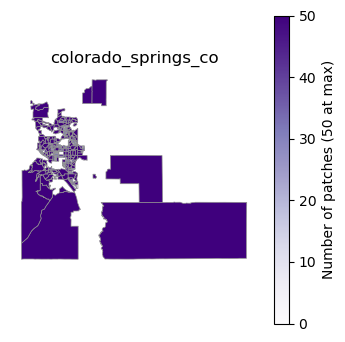

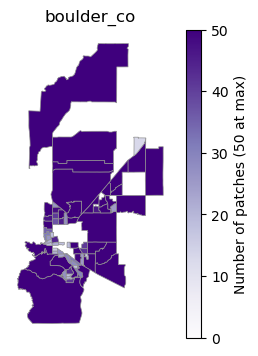

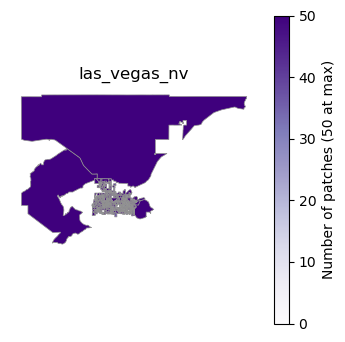

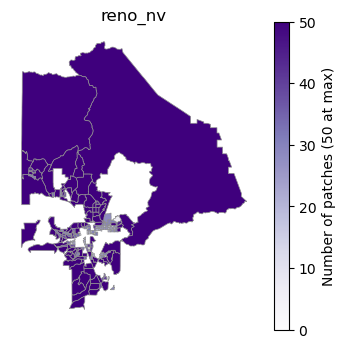

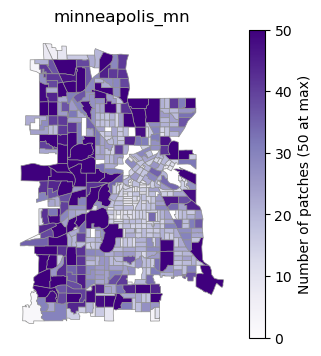

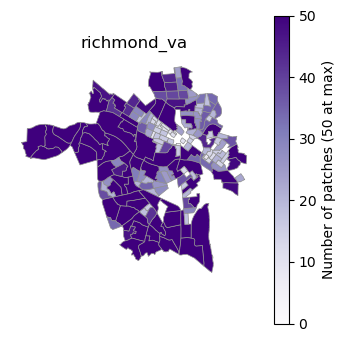

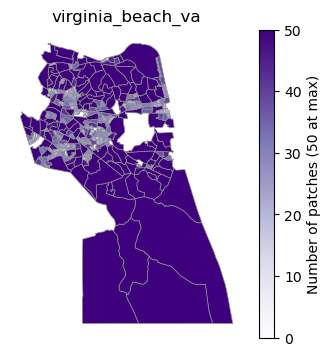

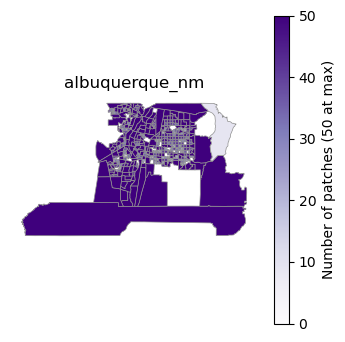

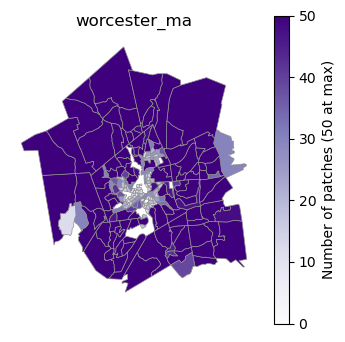

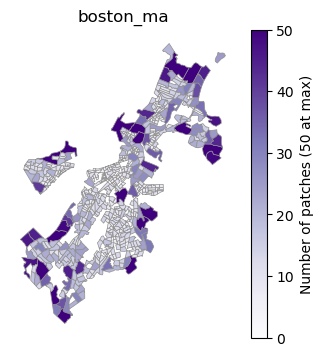

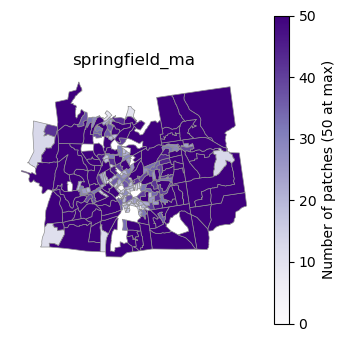

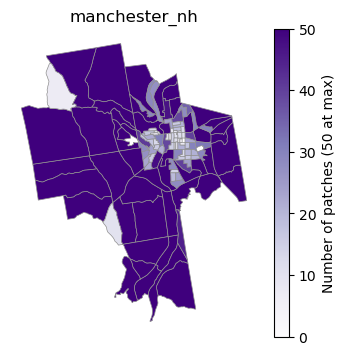

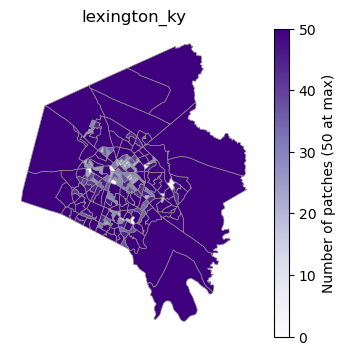

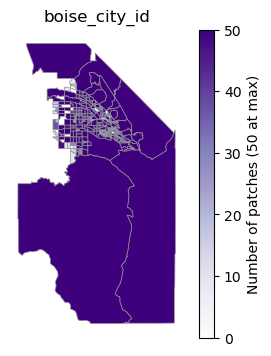

In [76]:
unique_cities = blocks_df.city_state.unique()
for city_state in unique_cities:
    fig, ax = plt.subplots(figsize=(4, 4))
    blocks_df[blocks_df.city_state == city_state].plot(
        ax=ax, 
        ec= "#909090", 
        lw = 0.5,  
        column = "n_patches", 
        cmap = "Purples",
        legend=True,
        legend_kwds={"label": "Number of patches (50 at max)"},
        vmax = 50,
        vmin = 0
        )
    plt.axis("off")
    plt.title(city_state)
    plt.show()

### Visualizing some blocks

In [38]:
def plot_block_images(selected_block):
    patches_relation = selected_block.patches_relation.values[0]
    city_state = selected_block.city_state.values[0]
    filenames_short = [filename.split("/")[-1] for filename in patches_relation.keys()]
    
    # loading geojson of patches in this city
    patches_geo_df = glob.glob(f"../data/output/patches/{city_state}/*.geojson")
    patches_geo_df_list = []
    for f in patches_geo_df:
        temp_df = gpd.read_file(f)
        # keeping only the lines that are in the selected block
        temp_df = temp_df[temp_df.patche_filename.isin(filenames_short)]
        if temp_df.shape[0] > 0:
            patches_geo_df_list.append(temp_df)
    patches_geo_df = pd.concat(patches_geo_df_list)

    # plotting the patches
    fig, ax = plt.subplots(figsize=(6, 6))
    selected_block.plot(ax=ax, ec="red", lw=2, fc="none", zorder = 2)
    for i, row in patches_geo_df.iterrows():
        img = plt.imread(f"../data/output/patches/{city_state}/{row.patche_filename}")
        img = img.transpose(1, 0, 2)
        # flip image horizontally
        img = img[:, ::-1, :]
        # plot inside the patch bounds
        xmin, ymin, xmax, ymax = row.geometry.bounds
        ax.imshow(img, extent=[xmin, xmax, ymin, ymax], zorder = 1)
        x, y = row.geometry.exterior.coords.xy
        ax.plot(x, y, color="#909090", lw = 0.5, zorder = 3)

    #plot block polygon
    x, y = selected_block.geometry.values[0].exterior.coords.xy
    ax.plot(x, y, color="red", zorder = 3)
    plt.axis("off")
    plt.show()

Total of 1 scenes


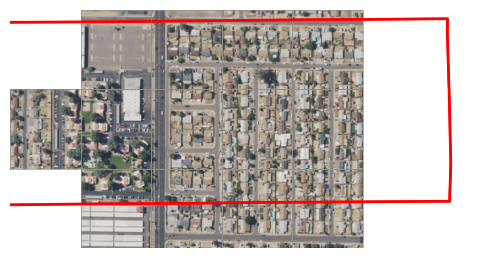

In [39]:
plot_block_images(blocks_df.head(1000).tail(1))

Total of 1 scenes


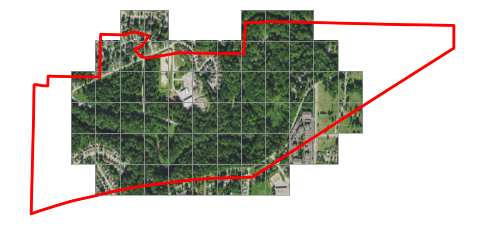

In [40]:
plot_block_images(blocks_df.sample(1))

Total of 1 scenes


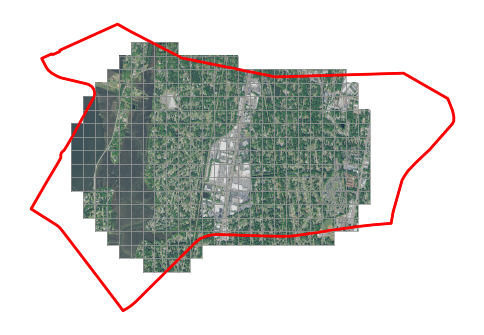

In [41]:
plot_block_images(blocks_df.sample(1))

Total of 1 scenes


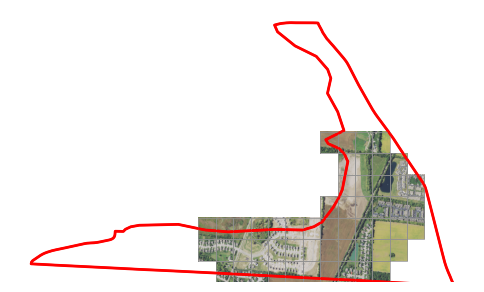

In [42]:
plot_block_images(blocks_df.sample(1))

Total of 1 scenes


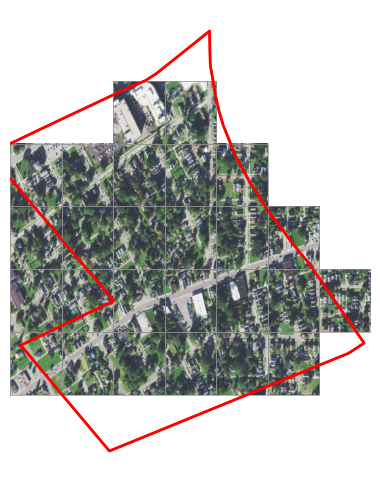

In [43]:
plot_block_images(blocks_df.sample(1))

Total of 1 scenes


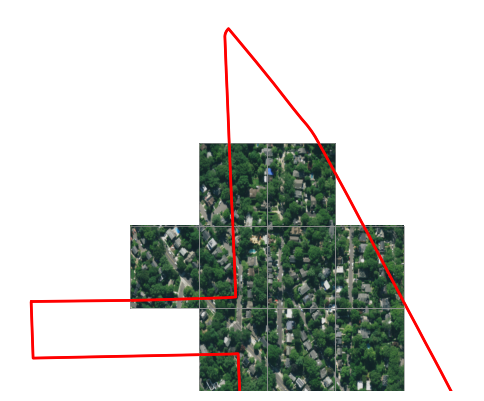

In [44]:
# get block with highest mhi
plot_block_images(blocks_df.sort_values("mhi", ascending=False).head(1))

Total of 1 scenes


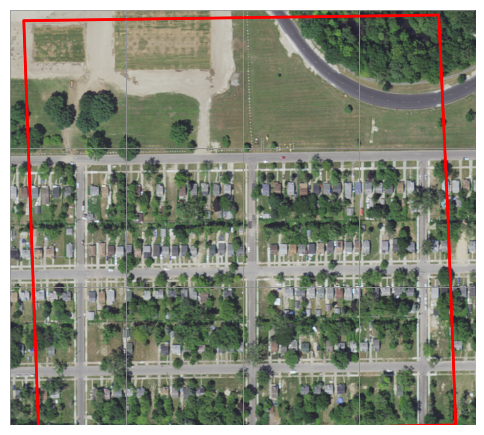

In [45]:
plot_block_images(blocks_df.sort_values("mhi").head(1))

### Verifying blocks and scenes intersection

In [29]:
unique_cities = blocks_df.city_state.unique()
scenes_shapefile = glob.glob("../data/scenes_metadata/*.geojson")
total_covered = 0
for city_state in unique_cities:
    blocks_df_city = blocks_df[blocks_df.city_state == city_state]
    scenes_shapefile_city = [f for f in scenes_shapefile if city_state in f]
    scenes_shapefile_city = pd.concat([gpd.read_file(f) for f in scenes_shapefile_city])
    scenes_shapefile_city = gpd.GeoDataFrame(scenes_shapefile_city, geometry="geometry")
    # project to projected coordinate system
    scenes_shapefile_city = scenes_shapefile_city.to_crs("EPSG:3857")
    blocks_df_city = blocks_df_city.to_crs("EPSG:3857")

    # for each block, verify the number of scenes that intersect with it
    n_scenes = blocks_df_city.apply(
        lambda x: scenes_shapefile_city.intersection(x.geometry).area / x.geometry.area,
        axis=1,
    )
    
    n_scenes = n_scenes.max(axis=1)
    not_covered = sum(n_scenes < 1)
    print(f"{city_state} has {not_covered}/{blocks_df_city.shape[0]} blocks not covered")
    total_covered += blocks_df_city.shape[0] - not_covered
print(f"Total of {total_covered}/{blocks_df.shape[0]} blocks covered")

seattle_wa has 125/470 blocks not covered
atlanta_ga has 92/321 blocks not covered
tucson_az has 149/532 blocks not covered
phoenix_az has 289/1472 blocks not covered
warwick_ri has 38/106 blocks not covered
washington_dc has 35/497 blocks not covered
indianapolis_in has 140/705 blocks not covered
trenton_nj has 34/124 blocks not covered
knoxville_tn has 143/267 blocks not covered
memphis_tn has 160/581 blocks not covered
nashville_tn has 169/456 blocks not covered
chattanooga_tn has 127/230 blocks not covered
detroit_mi has 109/754 blocks not covered
grand_rapids_mi has 65/276 blocks not covered
oklahoma_city_ok has 289/845 blocks not covered
tulsa_ok has 156/507 blocks not covered
huntsville_al has 120/250 blocks not covered
birmingham_al has 211/478 blocks not covered
st._louis_mo has 21/277 blocks not covered
kansas_city_mo has 190/719 blocks not covered
omaha_ne has 81/474 blocks not covered
fayetteville_ar has 61/117 blocks not covered
little_rock_ar has 78/198 blocks not covered

In [41]:
import paramiko
from osgeo import gdal

In [42]:
vidagpu_username = "gav9890"
vidagpu_password = "vida1309"
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(
    "vidagpu.poly.edu", username=vidagpu_username, password=vidagpu_password
)

In [46]:
sftp = ssh.open_sftp()
sftp.chdir("/vida/work/GDPFinder/GDPFinder/data/output/unzipped_files")
dir_contents = sftp.listdir()
    # keep only tif files
dir_contents = [f for f in dir_contents if f.endswith(".tif")]
entity_id =[f.split("_")[0] for f in dir_contents]

In [91]:
for city_state in unique_cities:
    blocks_df_city = blocks_df[blocks_df.city_state == city_state]

    # load scenes of city
    scenes_shapefile_city = [f for f in scenes_shapefile if city_state in f]
    scenes_shapefile_city = pd.concat([gpd.read_file(f) for f in scenes_shapefile_city])
    scenes_shapefile_city = gpd.GeoDataFrame(scenes_shapefile_city, geometry="geometry")

    # project to projected coordinate system
    scenes_shapefile_city = scenes_shapefile_city.to_crs("EPSG:3857")
    blocks_df_city = blocks_df_city.to_crs("EPSG:3857")
    
    # for each block
    for i, row in blocks_df_city.iterrows():
        # get scenes that intersect with it
        scenes_shapefile_city_block = scenes_shapefile_city[scenes_shapefile_city.intersection(row.geometry).area >= row.geometry.area]
        if len(scenes_shapefile_city_block) == 0:
            continue
        else:
            # get scene from entity id
            scenes_shapefile_city_block_entity_id = scenes_shapefile_city_block.entity_id.values[0]
            # get tif file from entity id
            tif_file = [f for f in dir_contents if f.split("_")[0] == scenes_shapefile_city_block_entity_id][0]

            sftp.get(tif_file, "temp.tif")
            tif = gdal.Open("temp.tif")
            row = gpd.GeoDataFrame(row).T
            row.crs = "EPSG:3857"
            row = row.to_crs(tif.GetProjectionRef())
            new_ds = gdal.Warp(
                "../data/output/blocks/" + str(i) + ".tif",
                tif,
                outputBounds=row.geometry.bounds.values[0],
                format = "GTiff",
            )
            new_ds = None
            
    break

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 